In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
import torch
import torch.nn as nn

In [3]:
# 데이터 로드
data = pd.read_csv('Google_Stock_Price_Train.csv')

# 필요한 열만 선택 (Date, Close)
data = data[['Date', 'Close']]

# 'Close' 칼럼의 쉼표 제거 및 float 변환
data['Close'] = data['Close'].str.replace(',', '').astype(float)

# 'Date' 열을 datetime 형식으로 변환
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

# 시계열 데이터 생성 (종가 데이터)
data = data['Close'].values

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape(-1, 1))

# 데이터 전처리 함수
def prepare_data(data, time_steps):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    x = np.array(x)
    y = np.array(y)
    return x, y

# 시계열 데이터 생성
time_steps = 60
x, y = prepare_data(data, time_steps)

# 데이터 형태 변경
x = x.reshape((x.shape[0], x.shape[1], 1))

# 학습 데이터와 테스트 데이터 분리
split = int(0.8 * len(x))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

# numpy 배열을 파이토치 텐서로 변환
x_train = torch.Tensor(x_train)
x_test = torch.Tensor(x_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

In [4]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size = 50, num_layers = 1, output_size = 1):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        out,  _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

In [5]:
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    outputs = model(x_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [5/20], Loss: 0.1108
Epoch [10/20], Loss: 0.0820
Epoch [15/20], Loss: 0.0627
Epoch [20/20], Loss: 0.0581


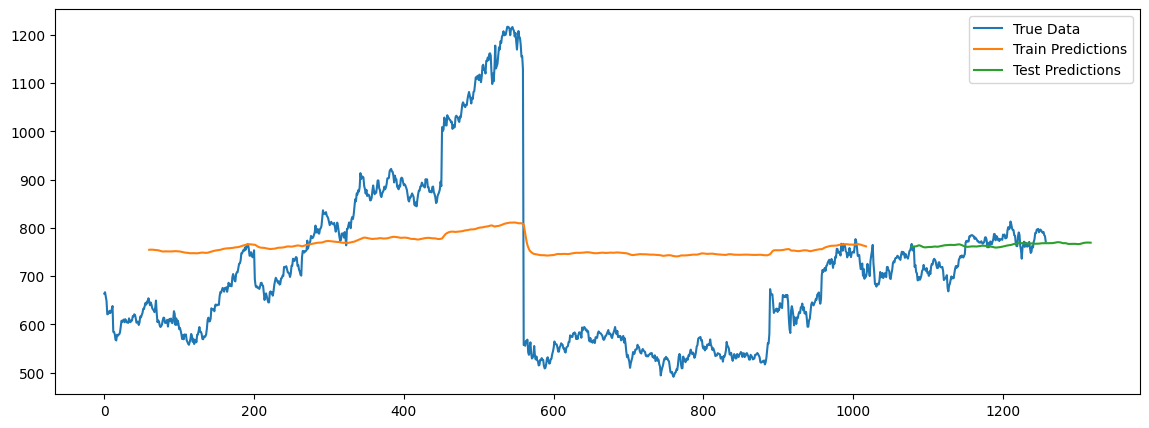

In [7]:
import matplotlib.pyplot as plt

# 모델을 평가 모드로 설정
model.eval()

# 학습 데이터와 테스트 데이터에 대한 예측
train_predictions = model(x_train).detach().numpy()
test_predictions = model(x_test).detach().numpy()

# 예측값과 실제값의 스케일을 원래대로 되돌림
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 결과 시각화
plt.figure(figsize=(14, 5))

# 전체 데이터 시각화
plt.plot(scaler.inverse_transform(data), label='True Data')

# 학습 데이터에 대한 예측 시각화
plt.plot(np.arange(time_steps, len(train_predictions) + time_steps), train_predictions, label='Train Predictions')

# 테스트 데이터에 대한 예측 시각화
plt.plot(np.arange(len(train_predictions) + 2 * time_steps, len(train_predictions) + 2 * time_steps + len(test_predictions)), test_predictions, label='Test Predictions')

plt.legend()
plt.show()